# Title

## Introduction

Heart disease is the second leading cause of death in Canada, and occurs due to a build up of plaque in a person’s arteries. It can lead to a heart attack, heart failure, or death. Many factors can increase a person’s likelihood of getting a heart disease diagnosis, such as age and sex (via [Government of Canada](https://www.canada.ca/en/public-health/services/publications/diseases-conditions/heart-disease-canada.html)). 
With this project, we want to answer the question: **Can a person’s age, sex, resting blood pressure, cholesterol, fasting blood sugar, and susceptibility to exercise-induced anginas accurately predict if they will get diagnosed with heart disease?** To answer this question, we will be using a dataset from the Cleveland Clinic Foundation from 1988, which includes these various attributes for 303 patients, and whether or not they were diagnosed with heart disease.

## Preliminary Exploratory Data Analysis

In [1]:
#load packages
library(tidyverse) # needed for many functions used for data analysis, such as read_csv(), select(), etc.
library(repr) # needed to resize plots
library(tidymodels) # needed to split data into training and testing data and to perform classification

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

The dataset can be obtained from UC Irvine's Machine Learning Repository website: https://archive.ics.uci.edu/dataset/45/heart+disease via a zip file.

In [2]:
# read in dataset from web
url <- "https://archive.ics.uci.edu/static/public/45/heart+disease.zip"
download.file(url, "cleveland_data.zip")
unzip("cleveland_data.zip")
cleveland_original <- read_csv("processed.cleveland.data",
                          col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs",
                                        "restecg", "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

# preview first 5 rows of the dataframe
head(cleveland_original, 5)

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>
63,1,1,145,233,1,2,150,0,2.3,3,0.0,6.0,0
67,1,4,160,286,0,2,108,1,1.5,2,3.0,3.0,2
67,1,4,120,229,0,2,129,1,2.6,2,2.0,7.0,1
37,1,3,130,250,0,0,187,0,3.5,3,0.0,3.0,0
41,0,2,130,204,0,2,172,0,1.4,1,0.0,3.0,0


After reading in the dataset, we cleaned it to only contain the information that is relevant to our analysis and converted values of a certain column to make more sense. Specifically, the data set's information indicates that values 1, 2, 3, and 4 in the num column means that heart disease is present but does not indicate what differences in these values mean. So we converted num into a binary column (0 = no heart disease; 1 = presence of heart disease)

In [3]:
# select for columns we'll use
cleveland <- select(cleveland_original, age, sex, trestbps, chol, fbs, exang, num)

# convert num column to binary (0 = no heart disease; 1 = presence of heart disease)
cleveland <- cleveland |>
    mutate(num = ifelse(num != 0, 1, 0))

# preview first 5 rows of new dataframe
head(cleveland, 5)

age,sex,trestbps,chol,fbs,exang,num
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
63,1,145,233,1,0,0
67,1,160,286,0,1,1
67,1,120,229,0,1,1
37,1,130,250,0,0,0
41,0,130,204,0,0,0


We can then split our cleaned data into training and testing data, then perform exploratory data analysis on the training data.

In [4]:
# split the data then make training and testing data
cleveland_split <- initial_split(cleveland, prop = 0.75, strata = num)
cleveland_training <- training(cleveland_split)
cleveland_testing <- testing(cleveland_split)

To gain more insight into our training data, the following data tables were made to see the number of observations in each class of sex, fasting blood sugar level, and if an individual gets excercise induced angina (chest pain).

In [5]:
# Tables that report the number of observations in each class of sex, fasting blood sugar level, and if an individual has excercise induced angina.

# table for number of observations in each class of sex: (1 = male; 0 = female)
cleveland_train_sex <- cleveland_training |>
    group_by(sex) |>
    summarize(amount_of_individuals = n())

cleveland_train_sex

# table for number of observations in each class of fbs: (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
cleveland_train_fbs <- cleveland_training |>
    group_by(fbs) |>
    summarize(amount_of_individuals = n())

cleveland_train_fbs

# table for number of observations in each class of exang: exercise induced angina (1 = yes; 0 = no)
cleveland_train_exang <- cleveland_training |>
    group_by(exang) |>
    summarize(amount_of_individuals = n())

cleveland_train_exang

sex,amount_of_individuals
<dbl>,<int>
0,71
1,156


fbs,amount_of_individuals
<dbl>,<int>
0,188
1,39


exang,amount_of_individuals
<dbl>,<int>
0,151
1,76


We also found the means of the predictor variables (using only the training data) we planned to used in our analysis, as reported in the following table.

In [8]:
# table of means of the predictor variables
cleveland_train_means <- cleveland_training |>
    select(-num) |>
    map_df(mean)

cleveland_train_means

age,sex,trestbps,chol,fbs,exang
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
54.4978,0.6872247,132.2203,246.7225,0.1718062,0.3348018


To visualize the distributions of each numerical/non-binary predictor variables (age, resting blood pressure, and cholesterol level), we produced the following histograms.

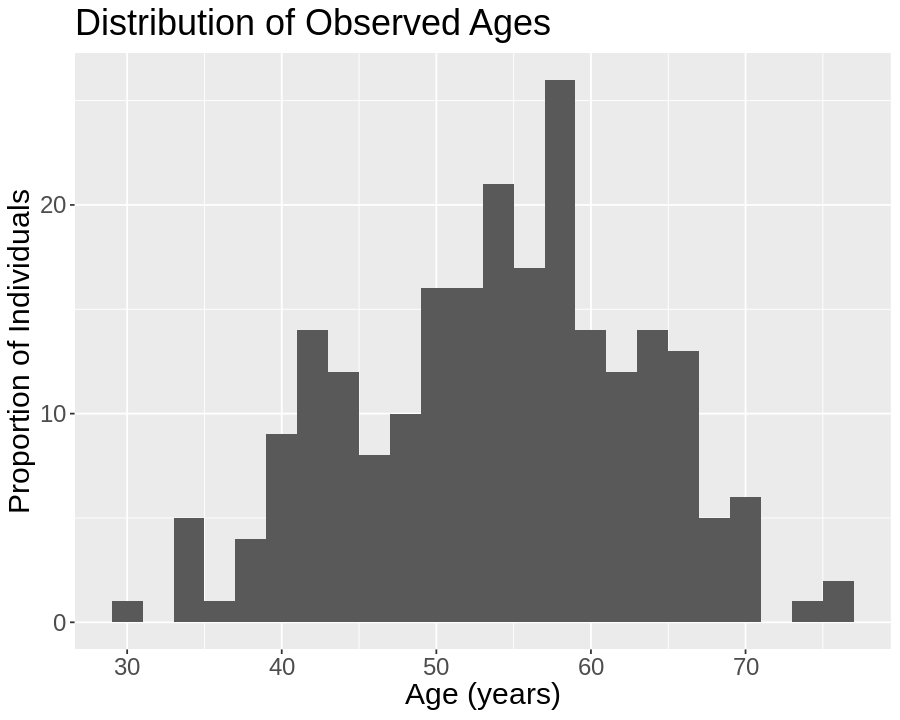

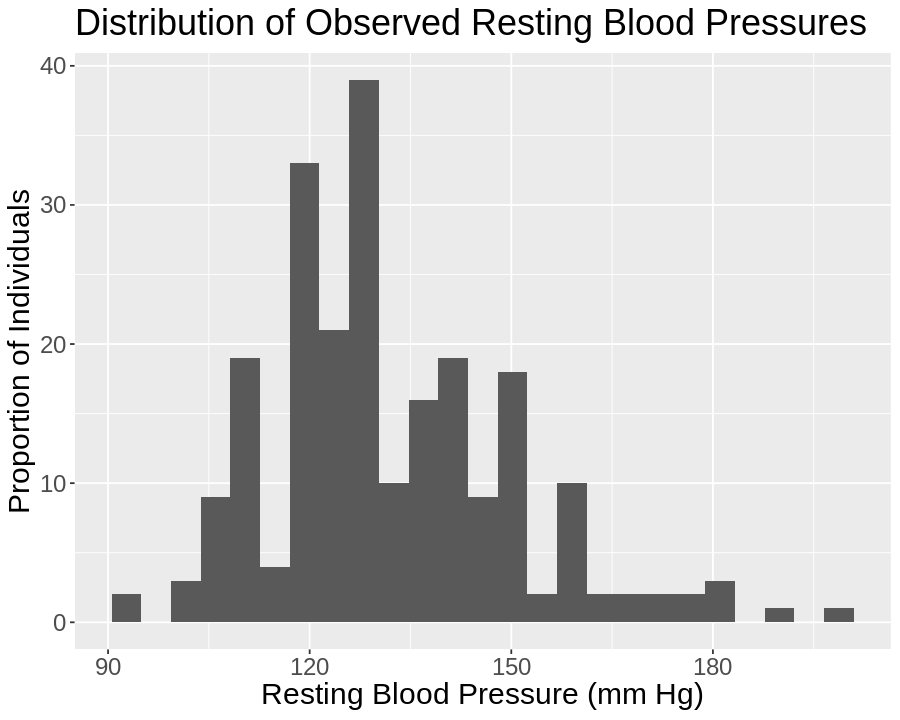

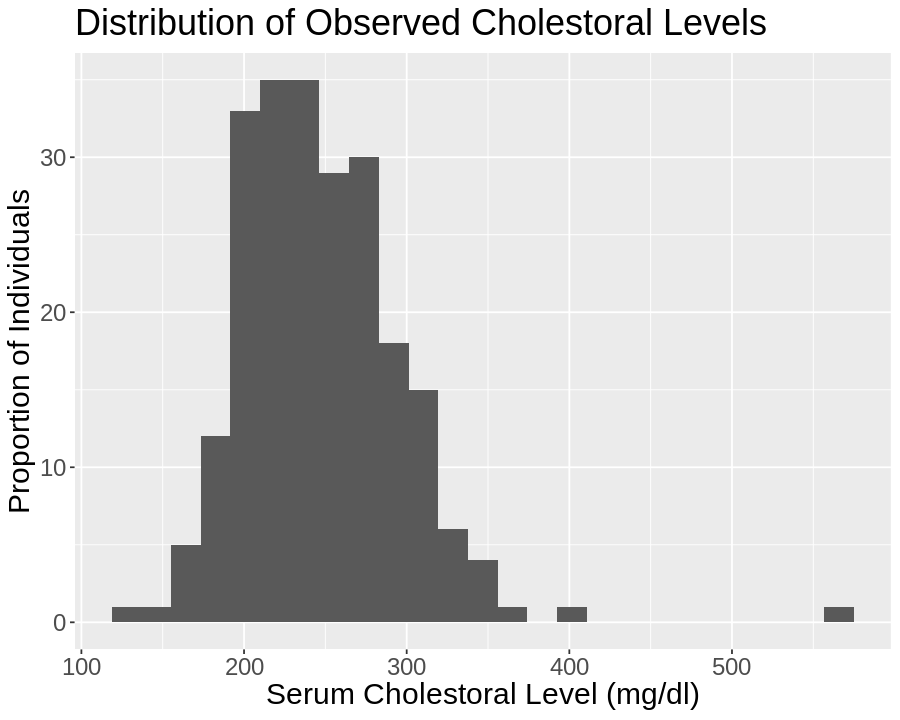

In [15]:
# histograms of non-binary variables

# set size of the plots
options(repr.plot.height = 6, repr.plot.width = 7.5)

# distribution of age
age_dist <- cleveland_training |>
    ggplot(aes(x = age)) +
    geom_histogram(bins = 25) +
    labs(x = "Age (years)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Ages") +
    theme(text = element_text(size = 18))
age_dist

# distribution of trestbps: resting blood pressure
trestbps_dist <- cleveland_training |>
    ggplot(aes(x = trestbps)) +
    geom_histogram(bins = 25) +
    labs(x = "Resting Blood Pressure (mm Hg)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Resting Blood Pressures") +
    theme(text = element_text(size = 18))
trestbps_dist

# distribution of chol: serum cholestoral
chol_dist <- cleveland_training |>
    ggplot(aes(x = chol)) +
    geom_histogram(bins = 25) +
    labs(x = "Serum Cholestoral Level (mg/dl)", y = "Proportion of Individuals") +
    ggtitle("Distribution of Observed Cholestoral Levels") +
    theme(text = element_text(size = 18))
chol_dist

## Methods

## Expected Outcomes and Significance

**What do you expect to find?**

Within this research, we expect to find a correlation between the variables we are testing for and an increased risk of heart disease. Specifically, age, sex, resting blood pressure, cholesterol, fasting blood sugar, and susceptibility to exercise-induced anginas would correlate with a person's probability of contracting heart diseases. 

**What impact could such findings have?**

Our findings could help those in the medical field better predict the likelihood of heart disease within their patients based on certain variables we are measuring. It could further indicate specific characteristics that would increase their chances of contracting a heart disease to individuals. 

**What future questions could this lead to?**

Our research will examine the correlation between these variables and the probability of contracting any heart disease. However, further research could be done surrounding types of heart diseases that models could predict and a combination of variables that could lead to a greater risk of heart diseases. 

